In [1]:
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.6f}'.format
import warnings
warnings.filterwarnings("ignore")
import os
import json
import time
import numpy as np
import re
from datetime import datetime, timedelta
import requests
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import reuters
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image

In [20]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /Users/mr50031ml/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mr50031ml/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mr50031ml/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/mr50031ml/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [2]:
def text_preprocess(text):
    toks = word_tokenize(text)
    toks = [t.replace(",", "") for t in toks]
    toks = [t.replace(".", "") for t in toks]
    toks = [t.replace("-", "") for t in toks]
    stop = stopwords.words('english') + ["'s","could","would"]
    punc = string.punctuation + "'""" + "``" + "''"
    toks = [t.lower() for t in toks if t.lower() not in stop]
    toks = [t for t in toks if t not in punc]
    toks = [t for t in toks if t != '']
    sent_pos = pos_tag(toks,tagset='universal')
    sent_pos_updated = []
    for item in sent_pos:
        tok = item[0]
        pos = item[1]
        if pos not in [".","NUM"]:
            item_tuple = (tok,pos)
            sent_pos_updated.append(item_tuple)
    def get_part_of_speech(pos):
        if pos == 'NOUN':
            part_of_speech = 'n'
        elif pos == 'VERB':
            part_of_speech = 'v'
        elif pos == 'ADJ':
            part_of_speech = 'a'
        elif pos == 'ADV':
            part_of_speech = 'r'
        else:
            part_of_speech = 's'
        return part_of_speech
    wnl = nltk.WordNetLemmatizer()
    lemmans = []
    for (w,p) in sent_pos_updated:
        part_of_speech = get_part_of_speech(p)
        lemman = wnl.lemmatize(w,pos=part_of_speech)
        lemmans.append(lemman)
    text_clean = " ".join(lemmans)
    return text_clean

In [3]:
def cal_word_freq(txt):
    '''
    create a list of word frequencies
    '''
    wc = WordCloud(min_word_length=3, background_color='white')
    text_dictionary = wc.process_text(txt)
    word_freq = {k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}
    freq = list(word_freq.items())
    return freq

In [4]:
def create_wordcloud_from_text(txt,stop_words):
    wc = WordCloud(stopwords=stop_words, 
                   collocations=True, 
                   collocation_threshold=5, 
                   background_color="white").generate(txt)
    plt.figure(figsize=(12,8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [5]:
def generate_word_frequencies(txt,stop_words):
    cv = CountVectorizer(stop_words=stop_words, ngram_range=(1, 3))
    corpus = [txt]
    X = cv.fit_transform(corpus)
    freq = X.toarray().flatten()
    bow = cv.get_feature_names_out()
    df_bow = pd.DataFrame(data={'bow':bow,'freq':freq}).sort_values(by=['freq'],ascending=False).reset_index(drop=True)
    txt2dict = df_bow.head(4000).set_index('bow').T.to_dict(orient='records')[0]
    return txt2dict

In [6]:
def create_wordcloud_from_frequencies(txt2dict,stop_words):
    wc = WordCloud(stopwords=stop_words, 
                   background_color="white").generate_from_frequencies(txt2dict)
    plt.figure(figsize=(12,8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [7]:
def create_wordcloud_from_text_w_mask(txt,stop_words):
    mask = np.array(Image.open("news_mask.png"))
    wc = WordCloud(stopwords=stop_words, 
                   collocations=True, 
                   collocation_threshold=5, 
                   max_words = 150,
                   background_color='white',
                   mask=mask, 
                   colormap='Set1',
                   contour_color='darkgreen',
                   contour_width=2).generate(txt)
    plt.figure(figsize=(24,16))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [8]:
df_feed = pd.read_csv('raw_data.csv')
df_feed.head()

,publishTime,asset_id,asset_name,asset_slug,asset_symbol,category,subcategory,source_name,source_type,title,summary,url
0,2024-04-03 00:00:00.000,b3d5d66c-26a2-404c-9325-91dc714a722b,Solana,solana,SOL,Protocol Management,New Supported Asset or Market,Watcher Guru,News,Cryptocurrency: Top 3 Altcoins That May Surge 50%–100% Post Bitcoin Halving,"- The upcoming Bitcoin Halving event is expected to lead to a surge in altcoin and meme coin prices.\n- Three altcoins that may experience a 50% to 100% surge post-Bitcoin Halving are Solana, Shiba Inu, and XRP.\n- Solana is expected to gain momentum with upcoming token airdrops and a liquidity injector in April 2024.\n- Shiba Inu has seen significant growth in the past year and is predicted to surge by 220% by April-May 2024.\n- XRP may experience a surge in price due to increased user interest and positive changes in its ongoing case with the SEC.\n- Ripple's price is expected to increase by 11% in April 2024 and potentially reach a maximum level of $0.680.",https://watcher.guru/news/cryptocurrency-top-3-altcoins-that-may-surge-50-100-post-bitcoin-halving
1,2024-04-03 00:00:54.000,21c795f5-1bfd-40c3-858e-e9d7e820c6d0,Ethereum,ethereum,ETH,Token Listing,Staking Service Listing,AMBCrypto,News,"Ethereum: Staking over trading? Read this, ETH holders!","- Ethereum staking is becoming more popular as users see value in earning passive revenue.\n- The staking participation rate for ETH has increased to 27% compared to 15.89% a year ago.\n- The increase in staked supply indicates a shift towards guaranteed, stable returns over risky trading.\n- The supply of ETH on exchanges has dropped to multi-year lows, accounting for just 11.6% of the total supply.\n- Despite the interest in staking, ETH has retraced 6.5% in the last 24 hours and is at risk of further decline.\n- Negative sentiment over ETH's spot ETF prospects may compound its woes, with just a 19% chance of approval according to Polymarket.",https://ambcrypto.com/ethereum-is-staking-the-best-choice-for-eth-holders-than-trading
2,2024-04-03 00:16:15.000,1d51479d-68f6-4886-8644-2a55ea9007bf,Uniswap,uniswap,UNI,Funding,Equity Funding,CoinTelegraph,News,Crypto VC Paradigm seeking up to $850M raise for fund: Report,"- Crypto VC firm Paradigm is in talks to raise between $750 million to $850 million for a new fund.\n- If successful, this would be the largest raise for a crypto fund since May 2022.\n- Paradigm's previous largest fund was $2.5 billion in November 2021.\n- Notable investments by Paradigm include Coinbase, Fireblocks, Uniswap, and FTX.\n- VC funding for crypto projects has been increasing, with March seeing $1.16 billion raised.\n- NFT-related VC funding dropped by 92% in 2023, in line with falling floor prices for major NFT collections.",https://cointelegraph.com/news/paradigm-seeks-850-millon-for-crypto-fund
3,2024-04-03 00:19:43.000,NaN,NaN,NaN,NaN,Token Listing,Fund or Index Listing,CryptoSlate,News,Grayscale falls behind in ETF outflows first time since launch as ARKB loses $87.5 million,"- Grayscale Bitcoin Trust (GBTC) had lower outflows for the first time since the launch of spot Bitcoin ETFs, with $82 million outflows.\n- ARK 21Shares (ARKB) experienced outflows of $87.5 million.\n- GBTC has seen $15 billion in net outflows since January, making it the only spot Bitcoin ETF with negative net flows.\n- BlackRock and Fidelity's Bitcoin ETFs, IBIT and FBTC, have gained popularity and attracted significant investment.\n- IBIT accounted for over half of BlackRock's yearly net inflows, while FBTC represented 70% of Fidelity's.\n- Both IBIT and FBTC have seen continuous cash inflows for 52 straight days, indicating strong investor confidence.",https://cryptoslate.com/grayscale-falls-behind-in-etf-outflows-first-time-since-launch-as-arkb-loses-87-5-million/
4,2024-04-03 00:30:00.000,NaN,NaN,NaN,NaN,Legal and Regulatory,New Regulation or Rules,Watcher Guru,News,Can Local Currencies Dethrone The US dollar?,"- The US dollar's credib

In [19]:
df_feed['summary_preprocessed'] = df_feed['summary'].apply(lambda x: text_preprocess(x))
df_feed[['summary','summary_preprocessed']].head(2)

,summary,summary_preprocessed
0,"- The upcoming Bitcoin Halving event is expected to lead to a surge in altcoin and meme coin prices.\n- Three altcoins that may experience a 50% to 100% surge post-Bitcoin Halving are Solana, Shiba Inu, and XRP.\n- Solana is expected to gain momentum with upcoming token airdrops and a liquidity injector in April 2024.\n- Shiba Inu has seen significant growth in the past year and is predicted to surge by 220% by April-May 2024.\n- XRP may experience a surge in price due to increased user interest and positive changes in its ongoing case with the SEC.\n- Ripple's price is expected to increase by 11% in April 2024 and potentially reach a maximum level of $0.680.",upcoming bitcoin halve event expect lead surge altcoin meme coin price altcoins may experience surge postbitcoin halve solana shiba inu xrp solana expect gain momentum upcoming token airdrop liquidity injector april shiba inu see significant growth past year predict surge aprilmay xrp may experience surge price due increase user interest positive change ongoing case sec ripple price expect increase april potentially reach maximum level
1,"- Ethereum staking is becoming more popular as users see value in earning passive revenue.\n- The staking participation rate for ETH has increased to 27% compared to 15.89% a year ago.\n- The increase in staked supply indicates a shift towards guaranteed, stable returns over risky trading.\n- The supply of ETH on exchanges has dropped to multi-year lows, accounting for just 11.6% of the total supply.\n- Despite the interest in staking, ETH has retraced 6.5% in the last 24 hours and is at risk of further decline.\n- Negative sentiment over ETH's spot ETF prospects may compound its woes, with just a 19% chance of approval according to Polymarket.",ethereum stake become popular user see value earn passive revenue stake participation rate eth increase compare year ago increase stake supply indicates shift towards guarantee stable return risky trading supply eth exchange drop multiyear low account total supply despite interest stake eth retrace last hour risk decline negative sentiment eth spot etf prospect may compound woe chance approval accord polymarket


In [21]:
txt = " ".join(df_feed['summary_preprocessed'].to_list())
word_freq = cal_word_freq(txt)
print(word_freq[:10])

[('bitcoin', 504), ('token', 458), ('include', 324), ('user', 316), ('market', 311), ('crypto', 296), ('increase', 284), ('price', 252), ('new', 229), ('use', 227)]


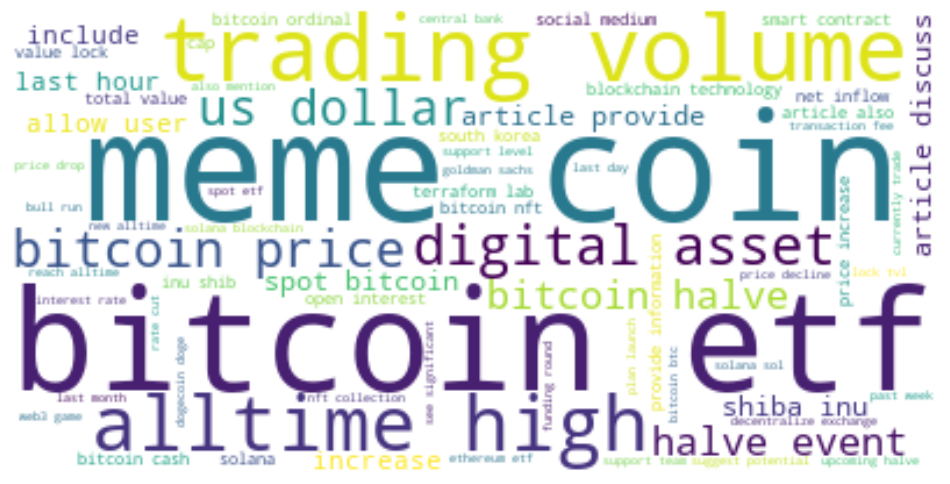

In [22]:
stop = ['market','crypto','token']
create_wordcloud_from_text(txt,stop)

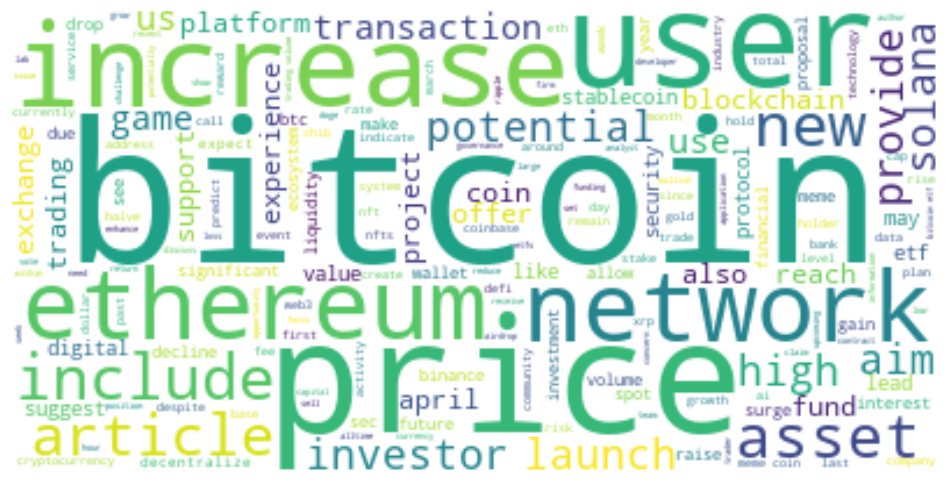

In [23]:
txt2dict = generate_word_frequencies(txt,stop)
create_wordcloud_from_frequencies(txt2dict,stop)

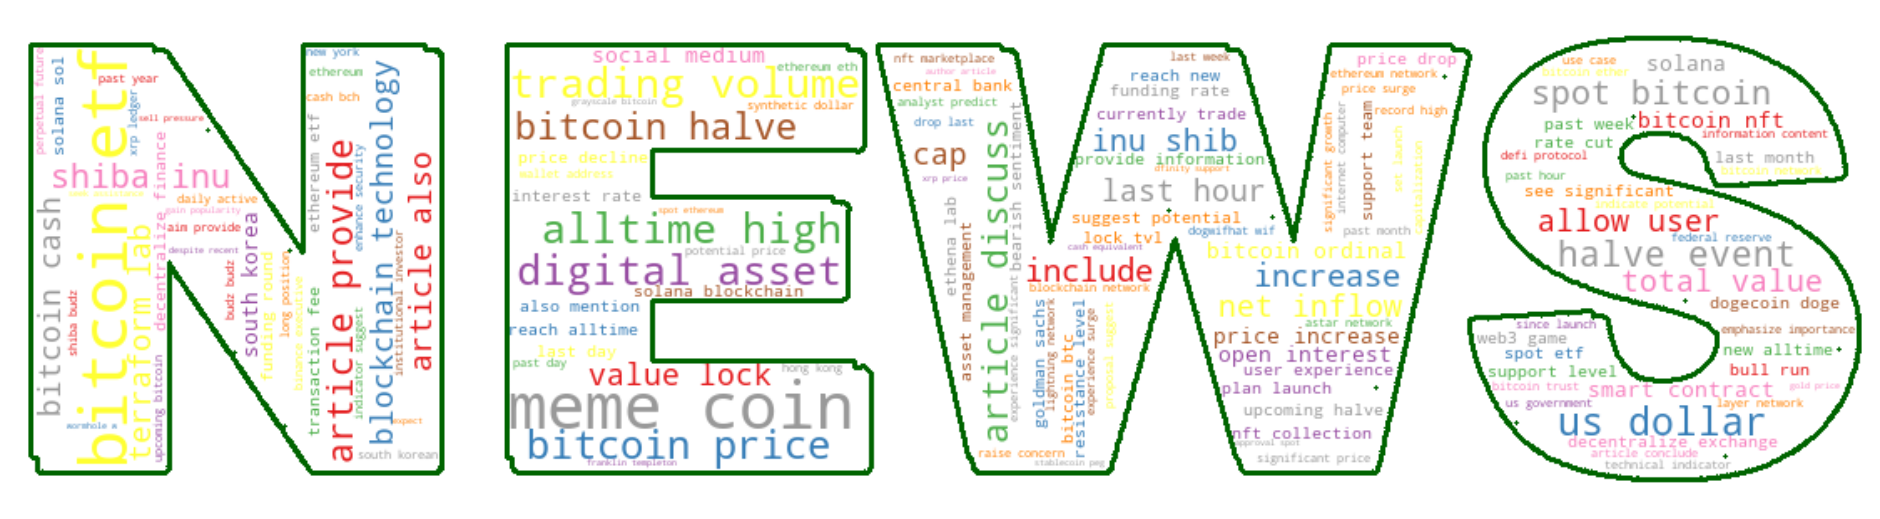

In [25]:
create_wordcloud_from_text_w_mask(txt,stop)